# 題目：Develop a prediction model for 2019 IEEE fraud detection challenge
## 姓名： 黃暐程

## 目錄：
1. Observed AUC Baseline by Logistic Regression
2. Feature Engineering
3. Improved Logistic Regression 
4. Tree-based model (XGboost)
5. Predicted testing dataset by XGboost model
6. Defined users and found fraud users

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from xgboost.sklearn import XGBClassifier
from xgboost import cv
import xgboost as xgb
from sklearn import preprocessing
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

/Users/wei-chenghuang/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/wei-chenghuang/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Loaded dataset and Merged it

In [2]:
train_identity = pd.read_csv("train_identity.csv")
train_transaction = pd.read_csv("train_transaction.csv")
test_transaction = pd.read_csv("test_transaction.csv")
test_identity = pd.read_csv("test_identity.csv")

In [3]:
print('Dimensions of the Train Identity set:',train_identity.shape)
print('Dimensions of the Train transaction set:',train_transaction.shape)
print('Dimensions of the Test transaction set:',test_transaction.shape)
print('Dimensions of the Test Identity set:',test_identity.shape)

Dimensions of the Train Identity set: (144233, 41)
Dimensions of the Train transaction set: (590540, 394)
Dimensions of the Test transaction set: (506691, 393)
Dimensions of the Test Identity set: (141907, 41)


In [3]:
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


In [3]:
train_df=pd.merge(train_transaction,train_identity,how="left",on="TransactionID")
test_df=pd.merge(test_transaction,test_identity,how="left",on="TransactionID")

Count Plot for Fraudulent vs legitimate transaction


0    96.500999
1     3.499001
Name: isFraud, dtype: float64

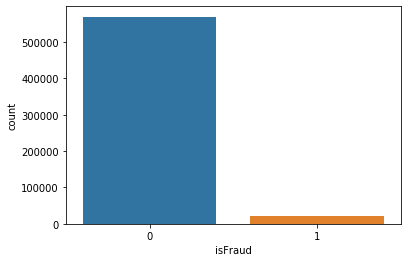

In [10]:
sns.countplot(train_df['isFraud'])
print("Count Plot for Fraudulent vs normal transaction") ## Imbalanced Dataset
train_df['isFraud'].value_counts(normalize=True) * 100

### 對dataset 做基本dimension 了解, 發現 DV 的分佈非常bias.

# 1. Observed AUC Baseline by Logistic Regression
###  ---- 對data 做基本的處理並試跑Logistic Regression, 觀察baseline 的AUC.

In [5]:
train_df_simple_baseline = train_df.copy()
test_df_simple_baseline= test_df.copy()

In [67]:
train_df_simple_baseline = train_df_simple_baseline.set_index("TransactionID")

In [70]:
#fill null value by mode
for i in train_df_simple_baseline.columns:
    train_df_simple_baseline[i].fillna(value=train_df_simple_baseline[i].mode()[0], inplace=True)

In [73]:
train_simple_y_baseline = train_df_simple_baseline['isFraud']
train_simple_x_baseline = train_df_simple_baseline.drop('isFraud', axis=1)

In [74]:
object_list = []
for f in train_simple_x_baseline.columns:
    if train_simple_x_baseline[f].dtype=='object': 
        object_list.append(f)
train_simple_x_baseline = pd.get_dummies(train_simple_x_baseline, columns= object_list, prefix=object_list)

In [75]:
train_simple_x_baseline.shape

(590540, 2833)

In [76]:
SEED = 123
random.seed(SEED)
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(train_simple_x_baseline, train_simple_y_baseline, test_size=0.3, random_state=42)


In [77]:
logistic_regression = LogisticRegression(solver="liblinear")
logistic_regression.fit(X_train_baseline,y_train_baseline)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

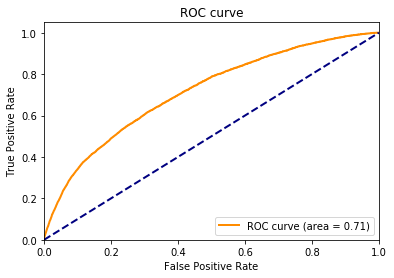

In [84]:
#ROC for baseline testing data
probs = logistic_regression.predict_proba(X_test_baseline)
preds = probs[:,1]
lw = 2
fpr, tpr, threshold = roc_curve(y_test_baseline, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### 小結: 做基本feature處理的 Logistic Regression 跑出AUC 0.71 當作baseline 來優化後續的model

# 2. Feature Engineering
* 去除超過60% missing value 的columns
* 根據distribution fill missing value
* 轉換 dummies variable

In [8]:
train_df_simple = train_df.copy()
test_df_simple = test_df.copy()

In [10]:
train_df.shape

(590540, 434)

In [6]:
# Check missing data - Many Columns have more than 60% Null value
def missing_data(df) :
    count = df.isnull().sum()
    percent = (df.isnull().sum()) / (df.shape[0]) * 100
    total = pd.concat([count, percent], axis=1, keys = ['Count', 'NUll Percent'])
    types = []
    for col in df.columns :
        dtypes = str(df[col].dtype)
        types.append(dtypes)
    total['dtypes'] = types
    
    return np.transpose(total)

missing_data(train_df)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Count,0,0,0,0,0,0,8933,1565,1577,4259,...,450258,512954,517251,512735,449555,449555,449555,449555,449730,471874
NUll Percent,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,...,76.2451,86.8619,87.5895,86.8248,76.1261,76.1261,76.1261,76.1261,76.1557,79.9055
dtypes,int64,int64,int64,float64,object,int64,float64,float64,object,float64,...,object,float64,object,object,object,object,object,object,object,object


In [12]:
cols_to_drop

array(['dist2', 'R_emaildomain', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13',
       'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144',
       'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152',
       'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160',
       'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168',
       'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176',
       'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184',
       'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192',
       'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200',
       'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208',
       'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216',
       'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224',
       'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232',
       'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240',
       

In [9]:
# drop columns with more than 60% missing value
null_percent = train_df_simple.isnull().sum()/train_df.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 60].index)
null_percent = test_df_simple.isnull().sum()/test_df_simple.shape[0]*100
cols_to_drop_test = np.array(null_percent[null_percent > 60].index)

train_df_simple = train_df_simple.drop(cols_to_drop, axis=1)
test_df_simple = test_df_simple.drop(cols_to_drop_test, axis=1)
train_df_simple= train_df_simple.drop('M5', axis = 1)

In [11]:
train_df_simple.shape

(590540, 225)

In [8]:
# fill null value by evaluate each columns' distribution 
def fillna(train_df_simple):
    train_df_simple['card4'].fillna("other_card4", inplace=True)
    train_df_simple['card6'].fillna("other_card6", inplace=True)
    train_df_simple['card2'].fillna(value=train_df_simple['card2'].mode()[0], inplace=True)
    train_df_simple['card3'].fillna(value=train_df_simple['card3'].mode()[0], inplace=True)
    train_df_simple['card5'].fillna(value=train_df_simple['card5'].mode()[0], inplace=True)
    train_df_simple['addr1'].fillna(value=train_df_simple['addr1'].mode()[0], inplace=True)
    train_df_simple['addr2'].fillna(value=train_df_simple['addr2'].mode()[0], inplace=True)
    c_lst = ['C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
    m_lst = ['M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8', 'M9']
    d_lst = ['D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']
    v_lst = ['V1', 'V2', 'V3', 'V4', 'V5',
           'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15',
           'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
           'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33',
           'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42',
           'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51',
           'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60',
           'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69',
           'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78',
           'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87',
           'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96',
           'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104',
           'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112',
           'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120',
           'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128',
           'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136',
           'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285',
           'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293',
           'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301',
           'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309',
           'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317',
           'V318', 'V319', 'V320', 'V321']
    for c in c_lst:
        train_df_simple[c].fillna(value=train_df_simple[c].mode()[0], inplace=True)
    for d in d_lst:
        train_df_simple[d].fillna(value=train_df_simple[d].mode()[0], inplace=True)
    for m in m_lst:
        train_df_simple[m].fillna(value= "other", inplace=True)
    for v in v_lst:
        train_df_simple[v].fillna(value= train_df_simple[v].mode()[0], inplace=True)
    train_df_simple["P_emaildomain"].fillna(value= "otherEmail", inplace=True)
    train_df_simple["dist1"].fillna(value= train_df_simple["dist1"].median(), inplace=True)
    train_df_simple= train_df_simple.set_index("TransactionID")
    return train_df_simple

In [9]:
train_df_simple = fillna(train_df_simple)

In [10]:
test_df_simple = fillna(test_df_simple)

In [11]:
# got dummies variable
def get_dummies(train_df_simple):
    object_list = []
    for f in train_df_simple.columns:
        if train_df_simple[f].dtype=='object': 
            object_list.append(f)
    train_df_simple = pd.get_dummies(train_df_simple, columns= object_list, prefix=object_list)
    return train_df_simple

In [12]:
train_df_simple = get_dummies(train_df_simple)
test_df_simple = get_dummies(test_df_simple)

In [98]:
train_df_simple.columns.difference(test_df_simple.columns)

Index(['P_emaildomain_scranton.edu'], dtype='object')

In [97]:
test_df_simple.columns.difference(train_df_simple.columns)

Index(['P_emaildomain_scranton.edu'], dtype='object')

In [13]:
# making both test and training dataset have same columns 
train_df_simple= train_df_simple.drop('card6_debit or credit', axis =1)
test_df_simple= test_df_simple.drop('P_emaildomain_scranton.edu', axis =1)

### 小結: 
* 這塊除了做以上的處理外, 還有想過對某些資料為編號類型的columns (像是addr1, addr2, card) 做 cutting columns by bins. 
* 原意是將編號類型但有順序意義的columns 轉換成區間的方式使用. 
* 例如 addr1, addr2 可能是類似行政區號的data, 做bins並設置適當的bins size預期可以讓同一區的資料合再一起.
* 但由於目前資訊無法推斷如何設置bins大小來達到此效果, 若將資料做不當的bins size 反而會遮蔽data本身能帶來的效果. 因此不做改動. 


# 3. Improved Logistic Regression 

In [7]:
print("train_df_simple: " , train_df_simple.shape)
print("test_df_simple: " , test_df_simple.shape)

train_df_simple:  (590540, 226)
test_df_simple:  (506691, 224)


In [14]:
train_simple_y = train_df_simple['isFraud']
train_simple_x = train_df_simple.drop('isFraud', axis=1)

In [34]:
#Standlized the dataset (result a little bit better than normalized it)
float_lst = []
for f in train_simple_x.columns:
    if train_simple_x[f].dtype=='float' or train_simple_x[f].dtype=='int': 
        float_lst.append(f)
for i in float_lst:
    train_simple_x[i] = (train_simple_x[i]-train_simple_x[i].mean())/train_simple_x[i].std()
    #train_simple_x[i] = (train_simple_x[i]-train_simple_x[i].min())/(train_simple_x[i].max()-train_simple_x[i].min())

In [42]:
SEED = 123
random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(train_simple_x, train_simple_y, test_size=0.3, random_state=42)

In [43]:
logistic_regression = LogisticRegression(solver="liblinear")
logistic_regression.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
#ROC for testing data
probs = logistic_regression.predict_proba(X_test)
preds = probs[:,1]
lw = 2
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

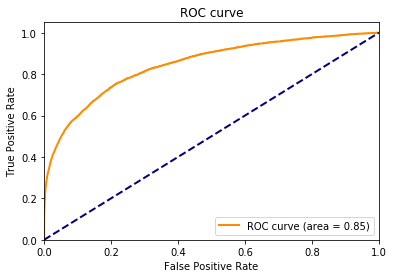

In [45]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [107]:
#ROC for training data
probs = logistic_regression.predict_proba(X_train)
preds = probs[:,1]
lw = 2
fpr, tpr, threshold = roc_curve(y_train, preds)
roc_auc = auc(fpr, tpr)
roc_auc

0.8441197670084698

### traing AUC (0.84) and testing AUC (0.85) 相差不大, 目前沒有看到overfitting的問題

In [46]:
model = sm.OLS(endog= y_train, exog= X_train)

In [48]:
result = model.fit()

In [87]:
# coefficient for logistic regression
# result.summary()
# 執行後的太佔空間, 不顯示於submit file 中

### 小結: Logistic Regression能達到 0.85 AUC 且沒有overfitting的情形發生. 要再近一步提升AUC 需要花大量時間進行feature research. 這邊先嘗試 fit tree-based model.

# 4. Tree-based model (XGboost)

In [15]:
train_simple_y_tree = train_df_simple['isFraud']
train_simple_x_tree = train_df_simple.drop('isFraud', axis=1)

In [17]:
SEED = 123
random.seed(SEED)
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_simple_x_tree, train_simple_y_tree, test_size=0.1, random_state=42)


In [38]:
SEED = 333
random.seed(SEED)
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train2, y_train2, test_size=0.1, random_state=42)

In [40]:
X_train3.shape

(478337, 310)

In [23]:
clf = XGBClassifier()
clf.fit(X_train3,y_train3,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
y_predprob = clf.predict_proba(X_test3)
y_predprob = y_predprob[:,1]

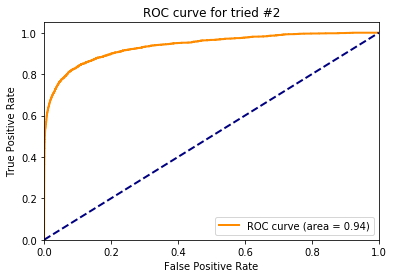

In [26]:
#Plot ROC curve 
lw = 2
fpr, tpr, threshold = roc_curve(y_test3, y_predprob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for tried #2')
plt.legend(loc="lower right")
plt.show()

In [27]:
y_predprob = clf.predict_proba(X_test2)
y_predprob = y_predprob[:,1]
fpr, tpr, threshold = roc_curve(y_test2, y_predprob)
roc_auc = auc(fpr, tpr)

In [28]:
roc_auc

0.9386217458128951

In [109]:
# observed AUC for training data set 
y_predprob_train = clf.predict_proba(X_train2)
y_predprob_train = y_predprob_train[:,1]

In [110]:
fpr, tpr, threshold = roc_curve(y_train2, y_predprob_train)
roc_auc = auc(fpr, tpr)
roc_auc

0.9558383822687903

### 在設XGboost parameter default 情況下 AUC已經可以得到0.94結果, 預期調整parameter帶來的提升比較有限, 因此用此training model 來做prediction. 

# 5. Predict testing dataset by XGboost model
    * 利用上面train 的model 找尋optimal threshold (最小化total cost)
    * 假定 false negative cost 極高, 為 false positive cost 的 100 倍
   

In [45]:
#got tpr, fpr by thresholds
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
roc.head()

,fpr,tpr,1-fpr,tf,thresholds
0,0.0,0.000000,1.0,-1.000000,1.999627
1,0.0,0.000158,1.0,-0.999842,0.999627
2,0.0,0.017663,1.0,-0.982337,0.996015
3,0.0,0.017978,1.0,-0.982022,0.996000
4,0.0,0.018136,1.0,-0.981864,0.995970


In [27]:
# kept tpr over 0.7 thresholds to caculate total cost
tprOver0_7_thresholds = roc.loc[roc["thresholds"] <0.1]
tprOver0_7_thresholds = tprOver0_7_thresholds.thresholds

In [32]:
# caculated total cost by each threshold
# false negative cost : false positive cost 100 : 1 
total_cost_lst = []
for cutoff in tprOver0_7_thresholds:
    y_predict = np.where(y_predprob >= cutoff, 1, 0)
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test2, y_predict)
    False_negative_cost = confusion_matrix[1][0]*100 
    False_positive_cost = confusion_matrix[0][1]
    total_cost = False_negative_cost + False_positive_cost
    total_cost_lst.append(total_cost)

In [56]:
print("Minimun total cost:", min(total_cost_lst))

Minimun total cost: 93683


In [58]:
optimal_threshold = tprOver0_7_thresholds[total_cost_lst.index(min(total_cost_lst))]
print("Optimal threshold: " , optimal_threshold)

Optimal threshold:  0.023098843


In [53]:
y_predict = np.where(y_predprob >= optimal_threshold, 1, 0)
confusion_matrix(y_test2, y_predict)

array([[142134,  28687],
       [   759,   5582]])

In [54]:
print(recall_score(y_test2, y_predict))

0.88030279135783


In [59]:
y_predprob_test = clf.predict_proba(test_df_simple)

In [60]:
y_predprob_test = y_predprob_test[:, 1]
y_predict_test = np.where(y_predprob_test >= optimal_threshold, 1, 0)

In [61]:
test_df_simple["isFraud"] = y_predict_test

### 小結：假設False Negative Cost : False Positive Cost  = 100 : 1
    * False Negative Cost (漏判斷 Frauds 的 Cost 極大)
    * False Positive Cost (Operation Cost, 部分User switching Cost)
    * 這邊的 optimal cut off 會是最小化 total cost , threshold 取0.023098843 可以得到 tpr 88% 定且得到 Minimun total   cost: $93683

# 6. Define users and find fraud users
    * 透過相同的user info (card1, card2, card3, card4, card5, card6, addr1, addr2) 來判別是否為同個user
    * 計算Train data set 每個User 有多少筆 Fraud transaction 
    * 計算Test data set 每個User 有多少筆 Fraud transaction (上一步model prediction 的結果 ) 
    * 定義Fraud User：User 有一筆以上Fraud transaction
    * 目標為低false negative (預測結果為not Fraud User，但事實上卻是Fraud User)

### Caculate fraud user in training data set

In [4]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [23]:
train_df_origin_user = train_df[["TransactionID", "card1", "card2", "card3", "card4", 
                                 "card5", "card6", "addr1", "addr2", "isFraud"]]
train_df_origin_user = train_df_origin_user.fillna(-999)
train_df_origin_user = train_df_origin_user.set_index("TransactionID")


In [24]:
train_df_origin_user = train_df_origin_user.sort_values(by=["card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2"])
train_df_origin_user['userInfo'] = train_df_origin_user[train_df_origin_user.columns[0:8]].apply(
    lambda x: ','.join(x.dropna().astype(str)),axis=1)

In [25]:
lst = [1]
user_index = 1
index_arr = train_df_origin_user.index
for i in range(1, len(index_arr)):
    if train_df_origin_user.loc[index_arr[i], "userInfo"] == train_df_origin_user.loc[index_arr[i-1], "userInfo"]:
            lst.append(user_index)
    else:
        user_index +=1
        lst.append(user_index)

train_df_origin_user["userID"] = lst 

In [38]:
train_df_fraud_user = train_df_origin_user[["userID", "isFraud"]].groupby(['userID']).sum()
Fraud_user_train = train_df_fraud_user.loc[train_df_fraud_user["isFraud"] >=1].rename(columns = {"isFraud": "Number Of Fraud transactions"})


In [41]:
Fraud_user_Id_array = np.array(Fraud_user_train.index)
print("Total user: ", len(train_df_fraud_user))
print("Fraud_user number: ",len(Fraud_user_Id_array))
print("Fraud user ID list: ", Fraud_user_Id_array)
print("Fraud user ratio: ", round(len(Fraud_user_Id_array)/ len(train_df_fraud_user), 2))

Total user:  43071
Fraud_user number:  3548
Fraud user ID list:  [   23    24    29 ... 43014 43015 43027]
Fraud user ratio:  0.08


### Predict fraud user in testing data set

In [62]:
#got origin test_df to distinguish transaction by user
test_df_origin=pd.merge(test_transaction,test_identity,how="left",on="TransactionID")

In [63]:
test_df_origin_user = test_df_origin[["TransactionID", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2"]]
test_df_origin_user["isFraud"] = y_predict_test
test_df_origin_user = test_df_origin_user.fillna(-999)
test_df_origin_user = test_df_origin_user.set_index("TransactionID")

/Users/wei-chenghuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
test_df_origin_user = test_df_origin_user.sort_values(by=["card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2"])

In [65]:
test_df_origin_user.head(10)

,card1,card2,card3,card4,card5,card6,addr1,addr2,isFraud
TransactionID,,,,,,,,,
4084529,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,0
4113026,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,1
4147003,1002,-999.0,150.0,mastercard,-999.0,credit,343.0,87.0,1
3981622,1003,452.0,150.0,mastercard,224.0,debit,264.0,87.0,0
4136498,1004,-999.0,-999.0,-999,-999.0,-999,126.0,87.0,0
4044940,1004,583.0,150.0,visa,226.0,credit,325.0,87.0,0
4056849,1004,583.0,150.0,visa,226.0,credit,325.0,87.0,0
4156127,1005,543.0,150.0,mastercard,117.0,debit,204.0,87.0,0
4128868,1006,399.0,150.0,american express,146.0,credit,231.0,87.0,0


In [66]:
test_df_origin_user['userInfo'] = test_df_origin_user[test_df_origin_user.columns[0:8]].apply(
    lambda x: ','.join(x.dropna().astype(str)),axis=1)

In [67]:
# 透過相同的user info (card1, card2, card3, card4, card5, card6, addr1, addr2) 來判別是否為同個user
lst = [1]
user_index = 1
index_arr = test_df_origin_user.index
for i in range(1, len(index_arr)):
    if test_df_origin_user.loc[index_arr[i], "userInfo"] == test_df_origin_user.loc[index_arr[i-1], "userInfo"]:
            lst.append(user_index)
    else:
        user_index +=1
        lst.append(user_index)

In [68]:
test_df_origin_user["userID"] = lst 

In [80]:
test_df_origin_user.head(5)

,card1,card2,card3,card4,card5,card6,addr1,addr2,isFraud,userInfo,userID
TransactionID,,,,,,,,,,,
4084529,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,0,"1001,555.0,150.0,visa,226.0,debit,269.0,87.0",1
4113026,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,1,"1001,555.0,150.0,visa,226.0,debit,269.0,87.0",1
4147003,1002,-999.0,150.0,mastercard,-999.0,credit,343.0,87.0,1,"1002,-999.0,150.0,mastercard,-999.0,credit,343...",2
3981622,1003,452.0,150.0,mastercard,224.0,debit,264.0,87.0,0,"1003,452.0,150.0,mastercard,224.0,debit,264.0,...",3
4136498,1004,-999.0,-999.0,-999,-999.0,-999,126.0,87.0,0,"1004,-999.0,-999.0,-999,-999.0,-999,126.0,87.0",4


In [69]:
# caculated number of fraud transaction for each user
test_df_fraud_user = test_df_origin_user[["userID", "isFraud"]].groupby(['userID']).sum()

In [70]:
# user with one or more than one time fraud transaction would be classify as a fraud user
Fraud_user = test_df_fraud_user.loc[test_df_fraud_user["isFraud"] >=1].rename(columns = {"isFraud": "Number Of Fraud transactions"})

In [71]:
Fraud_user.head()

,Number Of Fraud transactions
userID,
1,1
2,1
11,1
13,4
19,1


In [72]:
Fraud_user_Id_array = np.array(Fraud_user.index)

In [85]:
#Showing fraud user number and full list 
print("Total user: ", len(test_df_fraud_user))
print("Fraud_user number: ",len(Fraud_user_Id_array))
print("Fraud user ID list: ", Fraud_user_Id_array)
print("Fraud user ratio: ", round(len(Fraud_user_Id_array)/ len(test_df_fraud_user), 2))

Total user:  39538
Fraud_user number:  15016
Fraud user ID list:  [    1     2    11 ... 39532 39536 39537]
Fraud user ratio:  0.38


### Summary: 
### In the test set, 38% 的Users預測為Fraud_user, 比例可能有些過高. 但由於以商業上來講, 將Fraud user 預測為非Fraud user 的成本(false negative) 非常高. 根據先前的假設（FN cost : FP cost = 100 : 1), 此結果可以達到最小化total cost. 因此對這個結論是滿意的  